this model will operate on two learning rates based on condition and fits r_alpha

In [1]:
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os
from scipy.stats import norm
from scipy.optimize import minimize

### Define environment.

In [2]:
class Environment(object):
    
    """Class for the RP learning task

    Parameters 
    ----------

    n_actions : array, float 
        choosing the top or bottom stimulus

    r_p :
        reward probability with 80/20 contingency

    p_p :
        punishment probability with 80/20 contingency

    inv_rp :
        inverse reward probability 

    inv_pp :
        inverse punishment probability

    best_action : 
        pre-defined action that's the 'best'
        set as a np.random variable that's either 1 or 2 to randomize every time I initialize
        
    """

    def __init__(self, n_actions, r_p, p_p, inv_rp, inv_pp, best_action):
        
        self.n_actions = n_actions # choice of top or bottom stimulus

        self.r_p = r_p             # reward prob outcome
        self.p_p = p_p             # punishment prob outcome

        self.inv_rp = inv_rp       # inverse reward prob
        self.inv_pp = inv_pp       # inverse punishment prob

        self.best_action = best_action  # predefined best action

# Step Function: based on the condition, the environment returns an appropriate reward

    """
    Conditions are set such that 1 = Reward, 2=Punishment, 3=Neutral
    The best action is that which is associated with a higher probability of returning reward
        - Taking the best action returns a value of 1
        - Not taking the best action returns a value of 0 
        
    """

    def step(self, action, condition, trial):       # takes in condition  
        
        if condition == 1:                          ## Reward
            if action == self.best_action:                               
                reward = self.r_p[trial]            # index through r_p for 80% chance reward
                took_best_action = 1                # true, best action was taken 
            else: 
                reward = self.inv_rp[trial]         # index through inv_rp for 20% chance reward
                took_best_action = 0                # false 
                
        elif condition == 2:                        ## Punishment
            if action == self.best_action:
                reward = self.p_p[trial]
                took_best_action = 1                
            else:
                reward = self.inv_pp[trial] 
                took_best_action = 0
        else:                                       ## Neutral
            reward = 0
            took_best_action = 3        

        return reward, took_best_action, condition             # return condition agent's in to update 

### Define agent.

In [3]:
class Agent(object):

    """ Class for the agent to operate on a soft max policy when choosing between the two actions
    
    Parameters
    ----------
    r_alpha : float, range (0, 1)
        reward learning rate 
    p_alpha : float, range (0, 1)
        punishment learning rate
    beta : float, range (0, inf) 
      inverse temperature to control level of stochasticity in the choice
      **0 means the agent explores randomly 
      **large value approaching inf acts more deterministically
      
    """

    def __init__(self, env, r_alpha, p_alpha, beta, q_init= False):

        # initialize action space which is an array of all possible actions
        self.action_space = np.arange(env.n_actions) # 2 possible actions

        # initialize parameters
        self.r_alpha = r_alpha
        self.p_alpha = p_alpha
        self.beta = beta

        # initialize Q-values 
        if q_init: 
            self.q = q_init # assigns q to those initial values     
        else:   
            self.q = np.zeros((3, env.n_actions)) # otherwise they are 6 values of 0 (2 stimuli per condition)

        # initialize action counter, this counts how many times an action is taken
        self.action_counter = np.zeros((env.n_actions, ))
        
    # Learning policy
        
    def soft_max_policy(self, condition):        
        p = np.exp(self.beta * self.q[condition-1,:]) / (np.exp(self.beta * self.q[condition-1,:])).sum() # prob of choosing an action by condition        
        action = np.nonzero(np.random.random((1,)) <= np.cumsum(p))[0][0] + 1               
        return action # returns 1 or 2
    
    # Q-learning update function
  
    def update(self, condition, action, reward, verbose=False):
        if condition == 1: # reward trial
            self.action_counter[action-1] = self.action_counter[action-1] + 1        
            self.q[condition-1, action-1] = self.q[condition-1, action-1] + self.r_alpha*(reward - self.q[condition-1, action-1]) # update by condition
            # print('updated q values for reward trial' + str(self.q)) 
        elif condition == 2: # punishment trial 
            self.action_counter[action-1] = self.action_counter[action-1] + 1
            self.q[condition-1, action-1] = self.q[condition-1, action-1] + self.p_alpha*(reward - self.q[condition-1, action-1]) # update by condition
            # print('updated q values for punishment trial' + str(self.q)) 
          

### Define simulation function.

In [4]:
def RP_simulation(n_timesteps, n_trials_per_block, params, verbose=False):
    
    """Function for running one simulation of the RL model 
    specifying how the environment and agent interact 

    Parameters
    ----------
    
    n_timesteps :
        how many timesteps to run the simulation for
        
    params : dictionary containing parameters of the simulation 
        
        Environment parameters
        ----------------------
        n_actions: int 
            number of actions the agent can choose from 
        r_p : 
            possible returns from reward condition
        p_p : 
            possible returns from punishment condition
        inv_rp :
            inverse reward probability
        inv_pp :
            inverse punishment probability
        best_action: int
            which is the best action
            
        Agent parameters
        ----------------
        r_alpha : 
            reward learning rate
        p_alpha :
            punishment learning rate
        beta : 
            inverse temperature
        
    Returns
    -------
    
    sim_output: dictionary containing simulation output

        actions: array, int, shape(n_timesteps, )
            Action that the agent took on each timestep.

        rewards: array, float, shape(n_timesteps, )
            Rewards that the agent received on each timestep.

        optimal_action: array, boolean, shape(n_timesteps, )
            1 is true, 0 is false
            
        condition: 
            reward(1), punishment(2), neutral(3)
        
    """
    # initialize environment 
    env = Environment(params['n_actions'], params['r_p'], params['p_p'], params['inv_rp'], params['inv_pp'], params['best_action'])
    
    # initialize agent
    agent = Agent(env, params['r_alpha'], params['p_alpha'], params['beta'])
    
    # initialize output lists 
    A = [] # action taken 
    R = [] # reward taken
    OA = [] # was optimal action taken 
    C = [] # condition
    
    # Loop through trials
    
    a = np.tile([1], 30) # reward
    b = np.tile([2], 30) # punishment 
    c = np.tile([3], 30) # neutral
    d = np.concatenate([a,b,c])

    np.random.shuffle(d) # shuffle order of conditions 
    e = np.array_split(d,3)
        
    for i in np.arange(n_timesteps): # 3
        for t in np.arange(n_trials_per_block): # 30
            
            condition = e[i][t]
        
            # agent takes an action based on soft max policy which now takes in a condition parameter 
            action = agent.soft_max_policy(condition) 
            
            # environment responds with a reward 
            reward, took_best_action, condition = env.step(action, condition, t)

            # record action, reward, and optimal outcome result
            A.append(action)
            R.append(reward)
            OA.append(took_best_action)
            C.append(condition)

            # update 
            agent.update(condition, action, reward)
        
    sim_output = {
        'timestep': np.arange(n_timesteps)+1,
        'actions': np.array(A),
        'rewards': np.array(R),
        'optimal_action': np.array(OA),
        'condition': np.array(C)
    }
        
    return env, agent, sim_output

### Parameter Recovery

##### Define likelihood function.

In [5]:
# T is the number of trials, 90 
# L represents the log likelihood for all trials such that as you go through each trial you compute one value and that gets added on

def m2_loglikelihood(training_params, p_alpha, beta, actions, rewards, condition):
    
    r_alpha = training_params

    q_value = np.ones((3,2))*0.0 
    T = len(actions)
    L = 0  
    
    for t in range(T): 
        
        # compute choice probabilities of picking an action based on soft max 
        p = np.exp(beta * q_value[condition[t]-1,:]) / (np.exp(beta * q_value[condition[t]-1,:])).sum()

        # compute choice probability for actual choice based on the probability computed above by condition 
        choiceProb = p[actions[t]-1]

        # sum of the natural log of each individual choice probability to get the prob of a whole dataset (90 trials)
        L += np.log(choiceProb) 
    
        # update values with q learning, index for t and update by condition using the two separate learning rates
        if condition[t] == 1:
            q_value[condition[t]-1, actions[t]-1] = q_value[condition[t]-1, actions[t]-1] + r_alpha * (rewards[t] - q_value[condition[t]-1, actions[t]-1])
        elif condition[t] == 2:
            q_value[condition[t]-1, actions[t]-1] = q_value[condition[t]-1, actions[t]-1] + p_alpha * (rewards[t] - q_value[condition[t]-1, actions[t]-1])
    
    return -L   # this will return a negative log likelihood which is what we want to minimize to perform parameter recovery/fitting on


##### Define fitting function for minimizing likelihood.

In [7]:
'''
Fitting r_alpha
This fitting function returns a value for 'fun' which is the -LL & a value for 'x' which is the best fit alpha

'''

def fit_RP_Learning(p_alpha, beta, actions, rewards, condition):

    init_cond = np.array([np.random.uniform(0,1)])    
    bnds = [(1e-6,1)]
    optimum_output = minimize(m2_loglikelihood, init_cond, args=(p_alpha, beta, actions, rewards, condition), method='L-BFGS-B', bounds=bnds)
     
    return optimum_output

### Model Recovery

In [8]:
def model2_BIC(actions, rewards, condition):
    
    init_cond = np.array([np.random.uniform(0,1)]) # reward alpha
    bnds = [(1e-6,1)] 
    km = len(bnds) # number of parameters fit in the model

    optimum_output = minimize(m2_loglikelihood, init_cond, args=(p_alpha, beta, actions, rewards, condition), method='L-BFGS-B', bounds=bnds)    
    neg_loglikelihood = optimum_output.fun
    
    BIC = km * np.log(len(actions)) + 2*neg_loglikelihood
    
    return BIC

##### load model 1 functions

In [9]:
def model1_BIC(actions, rewards, condition):
    
    init_cond = [np.random.uniform(0,1)] # learning rate
    bnds = [(1e-6,1)]
    km = len(bnds) # number of parameters fit in the model
    
    optimum_output = minimize(m1_loglikelihood, init_cond, args=(beta, actions, rewards, condition), method='L-BFGS-B',bounds=bnds)    
    neg_loglikelihood = optimum_output.fun
    
    BIC = km * np.log(len(actions)) + 2*neg_loglikelihood
    return BIC

In [10]:
def m1_loglikelihood(alpha, beta, actions, reward, condition):
    
    q_value = np.ones((3,2))*0.0
    T = len(actions)
    L = 0  
    
    for t in range(T): # for every trial 
        
        # compute choice probabilities of picking an action based on soft max 
        p = np.exp(beta * q_value[condition[t]-1,:]) / (np.exp(beta * q_value[condition[t]-1,:])).sum()

        # compute choice probability for actual choice based on the probability computed above by condition 
        choiceProb = p[actions[t]-1]
 
        # sum of the natural log of each individual choice probability to get the prob of a whole dataset (90 trials)
        L += np.log(choiceProb) 
        
        # update values with q learning, index for t and update by condition 
        if condition[t] == 1 or condition[t] == 2:
            q_value[condition[t]-1, actions[t]-1] = q_value[condition[t]-1, actions[t]-1] + alpha * (reward[t] - q_value[condition[t]-1, actions[t]-1])

    return -L   # this will return a negative log likelihood which is what we want to minimize to perform parameter recovery/fitting on


##### Perform recovery.

In [15]:
# define parameters 
r_p = np.full((3, 8), 1, dtype=int)
r_p = np.append(r_p, [0, 0, 0, 0, 0, 0])
r_p = np.random.permutation(r_p)

p_p = np.full((3, 8), 0, dtype=int)
p_p = np.append(p_p, [-1, -1, -1, -1, -1, -1])
p_p = np.random.permutation(p_p)

inv_rp = np.full((24), 0, dtype=int)
inv_rp = np.append(inv_rp, [1, 1, 1, 1, 1, 1])
inv_rp= np.random.permutation(inv_rp)

inv_pp = np.full((24), -1, dtype=int)
inv_pp = np.append(inv_pp, [0, 0, 0, 0, 0, 0])
inv_pp = np.random.permutation(inv_pp)

n_timesteps = 3 # define how many times to loop through-- default to 3
n_trials_per_block = 30 # default to 30

best_action = np.random.choice(2) + 1   # action 1 or 2

### Initialize output list to simulate through different values of alpha
D = []

for i in np.arange(1,101): # number of simulations to run 
    print('this is simulation number ' + str(i))

    b = 5
    p_alpha = 0.3
    print('beta for this simulation is: ' + str(b))
    print('p_alpha for this simulation is, ' + str(p_alpha))
   
    for r_alpha in np.random.uniform(0,1,1):  # define how many values of alpha to simulate for
        print('r_alpha for this simulation is, ' + str(r_alpha))
                    
        print('best action = ' + str(best_action))

        for i in np.arange(n_timesteps):

            params = {
            'n_actions' : 2,
            'r_p': r_p,
            'p_p': p_p,
            'inv_rp': inv_rp,
            'inv_pp': inv_pp,
            'best_action' : best_action,
            'r_alpha' : r_alpha,
            'p_alpha' : p_alpha, 
            'beta' : b  
            }

        ### First, simulate with fixed parameter value. 
        _, _, sim_output = RP_simulation(n_timesteps, n_trials_per_block, params) # this returns actions, rewards, conditon, & optimal action cols

        # Convert to dataframe and append alpha, beta, rewards, & optimal action    
        d=pd.DataFrame(sim_output['actions'], columns = ['actions'])
        d.insert(1, 'r_alpha', r_alpha),
        d.insert(2, 'p_alpha', p_alpha),
        d.insert(3, 'beta', b),
        d.insert(4, 'rewards', sim_output['rewards']),
        d.insert(5, 'condition', sim_output['condition'])
        d.insert(6, 'optimal_action', sim_output['optimal_action']),
        d.insert(7, 'best_action', best_action)

        ### Then, fit simulated dataset to recover parameters. 
        ### PARAMETER RECOVERY
        
        print('Checking simulated dataset...')
        
        #  Obtain Log Likelihood function parameters (alpha, actions, rewards) using d   
        sim_r_alpha = d["r_alpha"].iloc[0]
    
        sim_p_alpha = d["p_alpha"].iloc[0]
        
        beta = d["beta"].iloc[0]
        
        actions = d['actions']
        
        rewards = d['rewards'].values
    
        condition = d["condition"].values
                
        ### Then, compute best fit alpha which comes from fitting function and is fit_alpha.x[0]
        
        res = fit_RP_Learning(sim_p_alpha, beta, actions, rewards, condition) # optimizer to return optimal outputs

        fit_r_alpha = res.x[0]
        print('fit reward alpha ' + str(fit_r_alpha))

        ### max LL gets computed with best fit parameters; alpha = fit_alpha.x[0]        

        max_LL = m2_loglikelihood(fit_r_alpha, sim_p_alpha, beta, actions, rewards, condition) # this is already returned as a negative in my fx
    
        LL_per_trial = np.exp(-max_LL/len(actions))
        print('likelihood per trial: ' + str(LL_per_trial))

        print('done running this simulation')
        
        BIC_model1 = model1_BIC(actions, rewards, condition) 
        BIC_model2 = model2_BIC(actions, rewards, condition)

        d.insert(8, 'log_likelihood', -max_LL),
        d.insert(9, 'fit_r_alpha', res.x[0]),
        d.insert(10, 'LL_per_trial', LL_per_trial)
        d.insert(11, 'model1_BIC', BIC_model1)
        d.insert(12, 'model2_BIC', BIC_model2)


        D.append(d)

        data = pd.concat(D, ignore_index=True)

this is simulation number 1
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.7777843903350473
best action = 1
Checking simulated dataset...
fit reward alpha 1.0
likelihood per trial: 0.6073042179635476
done running this simulation
this is simulation number 2
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.6044306646748021
best action = 1
Checking simulated dataset...
fit reward alpha 0.34284825852341994
likelihood per trial: 0.6698613714214443
done running this simulation
this is simulation number 3
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.008181023711492208
best action = 1
Checking simulated dataset...
fit reward alpha 0.04018895352005406
likelihood per trial: 0.5360133124456076
done running this simulation
this is simulation number 4
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simul

this is simulation number 32
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.024762747689534015
best action = 1
Checking simulated dataset...
fit reward alpha 0.001990521371376275
likelihood per trial: 0.5531796337301302
done running this simulation
this is simulation number 33
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.8134106778342549
best action = 1
Checking simulated dataset...
fit reward alpha 0.7683293687202928
likelihood per trial: 0.6227631767496924
done running this simulation
this is simulation number 34
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.5813480276656876
best action = 1
Checking simulated dataset...
fit reward alpha 0.4681293134059095
likelihood per trial: 0.6074337625459654
done running this simulation
this is simulation number 35
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_a

this is simulation number 61
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.522786980751362
best action = 1
Checking simulated dataset...
fit reward alpha 0.586442464063181
likelihood per trial: 0.627112414025549
done running this simulation
this is simulation number 62
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.9182345087193552
best action = 1
Checking simulated dataset...
fit reward alpha 0.9337132863217912
likelihood per trial: 0.6519918890008234
done running this simulation
this is simulation number 63
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.6290262406830496
best action = 1
Checking simulated dataset...
fit reward alpha 0.4234145145430001
likelihood per trial: 0.6986685485308216
done running this simulation
this is simulation number 64
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha fo

this is simulation number 91
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.21776146596362955
best action = 1
Checking simulated dataset...
fit reward alpha 0.05801411659281792
likelihood per trial: 0.5796995974090962
done running this simulation
this is simulation number 92
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.24856293990634803
best action = 1
Checking simulated dataset...
fit reward alpha 0.3425370204069083
likelihood per trial: 0.674834545219878
done running this simulation
this is simulation number 93
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this simulation is, 0.8322705044962977
best action = 1
Checking simulated dataset...
fit reward alpha 1.0
likelihood per trial: 0.6322878811754936
done running this simulation
this is simulation number 94
beta for this simulation is: 5
p_alpha for this simulation is, 0.3
r_alpha for this sim

In [16]:
data

,actions,r_alpha,p_alpha,beta,rewards,condition,optimal_action,best_action,log_likelihood,fit_r_alpha,LL_per_trial,model1_BIC,model2_BIC
0,1,0.777784,0.3,5,0,2,1,1,-44.885289,1.000000,0.607304,110.263078,94.270387
1,1,0.777784,0.3,5,1,1,1,1,-44.885289,1.000000,0.607304,110.263078,94.270387
2,1,0.777784,0.3,5,-1,2,1,1,-44.885289,1.000000,0.607304,110.263078,94.270387
3,2,0.777784,0.3,5,0,3,3,1,-44.885289,1.000000,0.607304,110.263078,94.270387
4,1,0.777784,0.3,5,0,3,3,1,-44.885289,1.000000,0.607304,110.263078,94.270387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1,0.572067,0.3,5,0,3,3,1,-41.465479,0.746097,0.630825,89.683616,87.430768
8996,1,0.572067,0.3,5,0,3,3,1,-41.465479,0.746097,0.630825,89.683616,87.430768
8997,1,0.572067,0.3,5,0,2,1,1,-41.465479,0.746097,0.630825,89.683616,87.430768
8998,1,0.572067,0.3,5,1,1,1,1,-41.465479,0.746097,0.630825,89.683616,87.430768


### visualizing parameter recovery

#### reward alpha

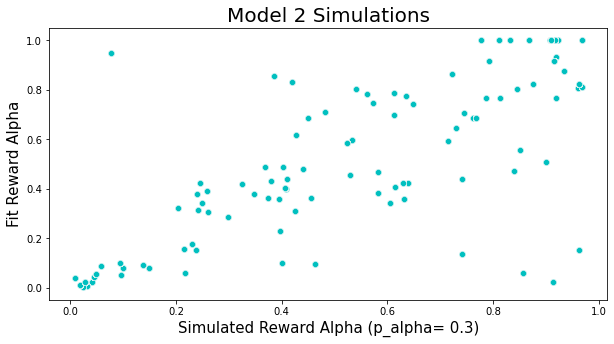

0.7032607434355458

In [17]:
fig, ax = plt.subplots(figsize = ( 10 , 5 ))

figure = sns.scatterplot(ax = ax, x = "r_alpha", y = "fit_r_alpha",
                data = data, color = "c")

# Set label for x-axis
ax.set_xlabel( "Simulated Reward Alpha " + "(p_alpha= " + str(p_alpha) + ")" , size = 15 )
  
# Set label for y-axis
ax.set_ylabel( "Fit Reward Alpha" , size = 15 )
  
# Set title for plot
ax.set_title( "Model 2 Simulations" , size = 20 )
  
# Display figure
#plt.plot([1, 0], [1, 0], linewidth=2)
plt.show()
data['r_alpha'].corr(data['fit_r_alpha'])

#### punishment alpha

In [ ]:
fig, ax = plt.subplots(figsize = ( 10 , 5 ))

figure = sns.scatterplot(ax = ax, x = "p_alpha", y = "fit_p_alpha",
                data = data, color = "c")

# Set label for x-axis
ax.set_xlabel( "Simulated Punishment Alpha " + "(r_alpha= " + str(r_alpha) + ")" , size = 15 )
  
# Set label for y-axis
ax.set_ylabel( "Fit Puishment Alpha" , size = 15 )
  
# Set title for plot
ax.set_title( "Model 2 Simulations" , size = 20 )
  
# Display figure
#plt.plot([1, 0], [1, 0], linewidth=2)
plt.show()
data['p_alpha'].corr(data['fit_p_alpha'])